# specifications : 
- modele 1 = autoencoder - CNN avec 6 convolutions - dataset = Mnist - TF_Keras
- modele 2 = autoencodeur debruiteur
- GPU - GeFORCE GTX 1060M 
- taux charge 87% GPU pour 20 Epochs
- Temperature des 7+1 CPU mesuree = 97 degres / temp rupteur du laptop = 100 degres

In [ ]:
# ==========================================================¶
# Date : 06 dec. 2018
# MS Valdom > apprenants > omar attaf, laurent lapasset, didier le picaut
# version = 1.0
# ==========================================================

In [1]:
# -*- coding: utf-8 -*-

In [ ]:
# ==========================================================¶
# modele 1 = autoencoder - CNN - Mnist - Keras 
# ==========================================================¶

In [2]:
# ===============
# CH1 : TO BUILD THE BACKEND
# ===============

In [3]:
# flecher le modele a utiliser le GPU (0) - [cf nvidia-smi]
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #le rx sera entraine avec le GPU-0

In [4]:
# ==  importer les libraries
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
# ===============
# CH2 :  DATA LOADER
# ===============

In [6]:
# == chargement des data
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf,dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [7]:
# appel fonction extract_data() - pqge yqnn lecun
# former les dataset train et test
# http://yann.lecun.com/exdb/mnist/
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [8]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [9]:
# mettre les labels au dataset
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [10]:
# ===============
# CH3 :  DATA DESCRIPTION
# ===============

In [11]:
# specifications des dataset image train
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# specifications des dataset image test
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [12]:
# dict noms de classe avec leurs étiquettes de classe catégoriques correspondantes:
# Create dictionary of target classes
label_dict = {
     0: 'A',
     1: 'B', 
     2: 'C',
     3: 'D',
     4: 'E',
     5: 'F',
     6: 'G',
     7: 'H',
     8: 'I',
     9: 'J',} 

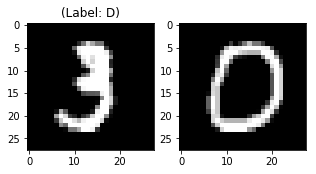

In [13]:
# plot quelques images
plt.figure(figsize=[5,5])

# image 121 - train
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# image 122 - test
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')

Text(0.5,1,'(Label: A)')

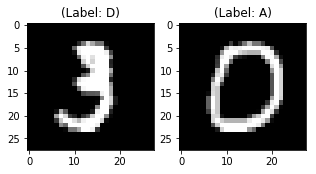

In [14]:
plt.figure(figsize=[5,5])

# 121 avec label = F
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# 122 avec label = H
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


In [15]:
# ==analyse : tous les 3 (train, test) sont D et tous les 0 (train, test) sont A

In [16]:
# Prétraitement des images en niveaux de gris 
# avec des valeurs de pixel allant de 0 à 255 avec une dimension de 28 x 28; 
# convertir chaque image de train / test 28 x 28 en une matrice de taille 28 x 28 x 1 

In [17]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [18]:
# sanity check le type des data
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [19]:
# sanity check valeur max pixel (255?)
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [20]:
# redim images train et images test avec valeur max pixel (255)
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [21]:
# sanity check la valmax des pixels images
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [22]:
# train decoupe en subsample (train, validation)
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,train_data,
                                                                test_size=0.2, random_state=13)

In [ ]:
# 80% en train, 20% en validation

In [23]:
# ===============
# CH3 :  MODEL DESCRIPTION
# ===============


In [24]:
# parametre de l apprentissage
batch_size = 64
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [25]:
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)                          #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)   #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)                          #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)  #7 x 7 x 128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)  #7 x 7 x 256 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6)                                     #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)   #14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7)                                       # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [26]:
# compilation du AE-CNN avec optimizer RMSprop
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [28]:
# sanity check - visualiser le rx AE Cnn
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [29]:
# Executer le modele : le Fit avec Keras
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 24s 509us/step - loss: 0.0197 - val_loss: 0.0125
Epoch 2/20
48000/48000 [==============================] - 22s 463us/step - loss: 0.0051 - val_loss: 0.0085
Epoch 3/20
48000/48000 [==============================] - 22s 464us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 4/20
48000/48000 [==============================] - 22s 466us/step - loss: 0.0030 - val_loss: 0.0043
Epoch 5/20
48000/48000 [==============================] - 22s 465us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 6/20
48000/48000 [==============================] - 22s 465us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 7/20
48000/48000 [==============================] - 22s 465us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/20
48000/48000 [==============================] - 22s 466us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/20
48000/48000 [==============================] - 22s 468us/step - loss: 0.0017 - val_

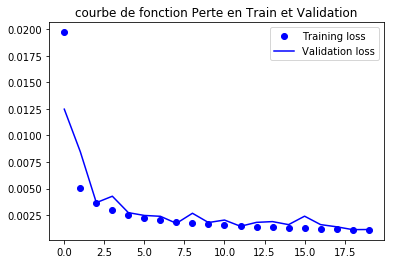

In [35]:
# diagramme de perte entre les données formation et validation pour visualiser les performances du modèle
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('courbe de fonction Perte en Train et Validation')
plt.legend()
plt.show()

In [ ]:
# analyse : au bout de 20 Epochs la valeur fct perte en validation = 1.1%
# les courbes pertes en Train et Validation sont synchronisees (et proches)
# on peut dire que la généralisation de notre modèle est bonne.

In [31]:
# Reconstruire les images de test à l’aide de la predict()
# prediction sur test
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Images Test


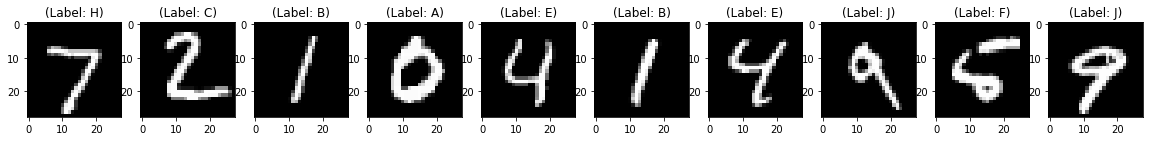

Reconstruction des Images Test


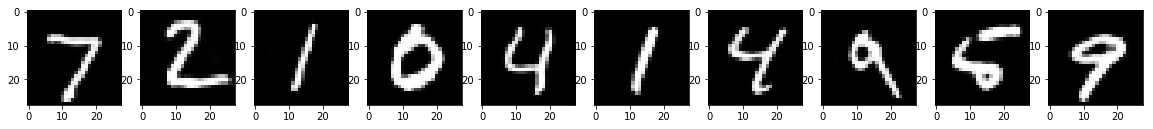

In [33]:
# sanity check visuel
# comparaison image et image reconstruite en test
plt.figure(figsize=(20, 4))
print("Images Test")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction des Images Test")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
# analyse: au bout de 20 Epochs, la reconstruction des images test semble correcte.

In [ ]:
##########################################################################################

In [ ]:
# ==========================================================¶
# modele 2 = le model 1 en usage autoencodeur debruiteur
# ==========================================================¶

In [36]:
# Détecteur automatique de bruit :
# -------------------------
# Un autencodeur de débruitage essaie d'apprendre une représentation 
# (espace latent ou goulot d'étranglement) robuste au bruit. 
# on ajoute du bruit aux images, puis on alimente notre modele1 forme.
# La partie encodeur de l'autoencodeur transforme
# l'image en un espace différent qui tente de conserver les formes des chiffres 
# tout en supprimant le bruit.

In [ ]:
# forme de bruit rajouter aux images
# -------------------------
# un facteur de bruit est un hyperparamètre. 
# Le facteur de bruit est multiplié par une matrice aléatoire ayant une moy=0,0 
# et un EC=1,0. 

In [37]:
# choc de bruit avec un multiplicateur = 0.5
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

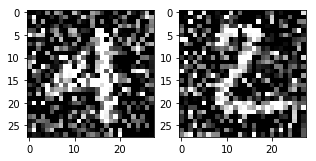

In [38]:
# sanity check - visuels de 2 images bruitees
plt.figure(figsize=[5,5])

# ligne 121 en train
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# ligne 122 en test
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [ ]:
#  analyse : les chiffres 4, 2 sont bruites

In [39]:
# parametre de l apprentissage
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [40]:
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)                          #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)   #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)                          #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)  #7 x 7 x 128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)  #7 x 7 x 256 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6)                                     #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)   #14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7)                                       # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [41]:
# compilation du AE-CNN avec optimizer RMSprop
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [42]:
# Executer le modele : le Fit avec Keras et les images bruitees
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 20s 426us/step - loss: 0.0355 - val_loss: 0.0217
Epoch 2/20
48000/48000 [==============================] - 19s 386us/step - loss: 0.0150 - val_loss: 0.0135
Epoch 3/20
48000/48000 [==============================] - 19s 385us/step - loss: 0.0126 - val_loss: 0.0142
Epoch 4/20
48000/48000 [==============================] - 19s 386us/step - loss: 0.0114 - val_loss: 0.0111
Epoch 5/20
48000/48000 [==============================] - 19s 386us/step - loss: 0.0107 - val_loss: 0.0117
Epoch 6/20
48000/48000 [==============================] - 19s 386us/step - loss: 0.0101 - val_loss: 0.0122
Epoch 7/20
48000/48000 [==============================] - 19s 387us/step - loss: 0.0096 - val_loss: 0.0106
Epoch 8/20
48000/48000 [==============================] - 19s 387us/step - loss: 0.0092 - val_loss: 0.0105
Epoch 9/20
48000/48000 [==============================] - 19s 387us/step - loss: 0.0089 - val_

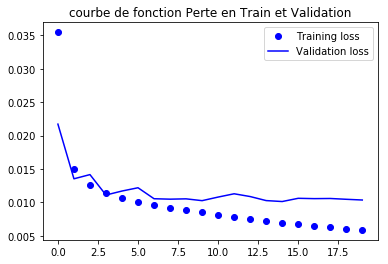

In [43]:
# diagramme de perte entre les données formation et validation pour visualiser les performances du modèle
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('courbe de fonction Perte en Train et Validation')
plt.legend()
plt.show()

In [ ]:
# analyse : 
# la perte de validation > la perte de train (ie resultat nominal)
# les 2 fonctions de pertes s ecartent en fct de la consommation des Epochs

In [44]:
# Reconstruire les images de test à l’aide de la predict()
# prediction sur test
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Images Test


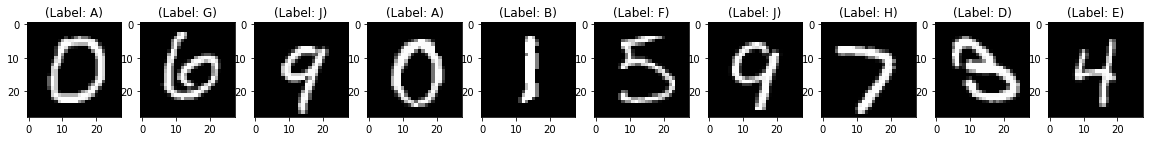

Images Test avec du bruit


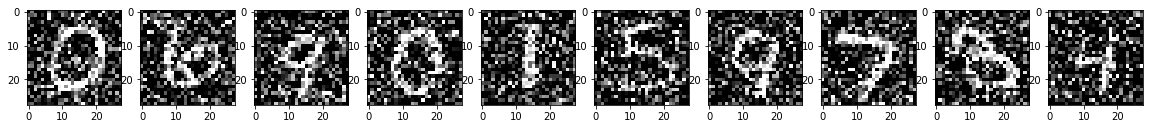

Images Test bruitees et reconstruites


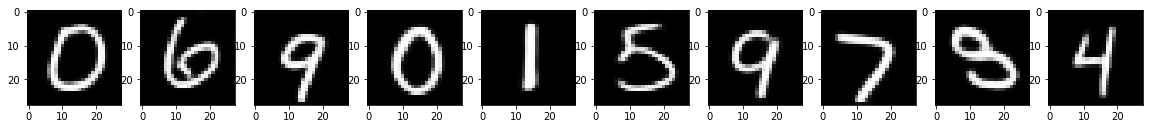

In [46]:
# sanity check visuel
# comparaison image avec image bruitee et image bruitee reconstruite en TEST
plt.figure(figsize=(20, 4))
print("Images Test")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Images Test avec du bruit")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Images Test bruitees et reconstruites")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
# conclusion : les images chiffres sont reconstruites a l origine et le bruit est efface.
# le modele 2 = (modele 1 CNN 6 convolutions) peut etre utilise en AE debruiteur d image